In [175]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
import fitsio
from tqdm import tqdm

from astroquery.jplhorizons import Horizons
from sbident import SBIdent

from tess_ephem import ephem, TessEphem, log
from tess_asteroid_ml import *
from tess_asteroid_ml.utils import *
from ipywidgets import *

In [209]:
sector = 4
camera = 1
ccd = 4
scc_str = f"s{sector:04}-{camera}-{ccd}"
scc_str

path = "/Volumes/ADAP-Kepler/Work/BAERI/data/tess/ffi"
cutout_size = 50

In [210]:
ffi_path = f"{path}/sector{sector:04}/tess2018307065939-{scc_str}-0124-s_ffic.fits"

In [211]:
with fits.open(ffi_path) as ffi:
    wcs = WCS(ffi[1])
    date_obs = Time([ffi[0].header["DATE-OBS"], ffi[0].header["DATE-END"]])

Set MJD-END to 58425.317815 from DATE-END'. [astropy.wcs.wcs]


In [212]:
col_2d, row_2d, f2d = load_ffi_image(
                "TESS",
                ffi_path,
                1,
                None,
                [0, 0],
                return_coords=True,
            )
ra_2d, dec_2d = wcs.all_pix2world(np.vstack([col_2d.ravel(), row_2d.ravel()]).T, 0.0).T
ra_2d = ra_2d.reshape(col_2d.shape)
dec_2d = dec_2d.reshape(col_2d.shape)

In [213]:
ffi_coord = SkyCoord(ra_2d*u.deg, dec_2d*u.deg, frame='icrs', obstime=date_obs.mean().isot)

In [214]:
jpl_sbi_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/jpl_small_bodies_tess_{scc_str}_results.csv"

if os.path.isfile(jpl_sbi_file):
    print("Loading from CSV file...")
    jpl_sb = pd.read_csv(jpl_sbi_file, index_col=0)

jpl_sb_bright = jpl_sb.query("V_mag <= 18")
jpl_sb_bright

Loading from CSV file...


,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,name,id
0,23 Thalia (A852 XA),02:17:25.69,+04:42:15.7,833.0,10000.0,13000.0,10.4,-42.45,-3.11700,34.357042,4.704361,10.4,23 Thalia,A852 XA
1,307 Nike (A891 EB),01:53:36.70,+01:45:59.6,-20000.0,2000.0,21000.0,13.6,-33.81,-6.22300,28.402917,1.766556,13.6,307 Nike,A891 EB
2,318 Magdalena (A891 SA),01:49:45.14,-01:12:56.7,-20000.0,-9000.0,26000.0,14.1,-28.23,-11.98000,27.438083,-1.215750,14.1,318 Magdalena,A891 SA
3,470 Kilia (A901 HC),02:26:54.90,+05:54:19.7,9000.0,20000.0,19000.0,13.6,-37.99,-15.79000,36.728750,5.905472,13.6,470 Kilia,A901 HC
4,567 Eleutheria (A905 KB),02:10:48.23,+07:44:09.8,-5000.0,20000.0,24000.0,14.0,-32.31,-4.95300,32.700958,7.736056,14.0,567 Eleutheria,A905 KB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,253978 (2004 ED28),02:15:00.15,+05:22:37.5,-1000.0,20000.0,15000.0,17.8,-33.74,-14.93000,33.750625,5.377083,17.8,253978,2004 ED28
1760,258102 (2001 QO170),02:32:29.50,+06:45:41.8,10000.0,20000.0,25000.0,17.5,-34.04,-69.97000,38.122917,6.761611,17.5,258102,2001 QO170
2076,307615 (2003 QR82),01:58:50.29,+03:09:40.9,-20000.0,7000.0,17000.0,17.9,-33.12,-4.50300,29.709542,3.161361,17.9,307615,2003 QR82
2096,310435 (2000 AV156),02:21:48.69,-01:38:17.5,5000.0,-10000.0,11000.0,18.0,-37.77,10.71000,35.452875,-1.638194,18.0,310435,2000 AV156


In [215]:
sb_ephems_lowres = {}

for k, row in jpl_sb_bright.iterrows():
    
    feath_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/tracks/sector{sector:04}/tess-ffi_s0004-0-0_{row['id'].replace(' ', '-')}_hires.feather"
    if os.path.isfile(feath_file):
        sb_ephems_lowres[k] = pd.read_feather(feath_file)

In [216]:
val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 117 to 142
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             26 non-null     float64
 1   sector           26 non-null     int64  
 2   camera           26 non-null     int64  
 3   ccd              26 non-null     int64  
 4   column           26 non-null     float64
 5   row              26 non-null     float64
 6   pixels_per_hour  26 non-null     float64
 7   ra               26 non-null     float64
 8   dec              26 non-null     float64
 9   vmag             26 non-null     float64
 10  sun_distance     26 non-null     float64
 11  obs_distance     26 non-null     float64
 12  phase_angle      26 non-null     float64
dtypes: float64(10), int64(3)
memory usage: 2.8 KB


In [217]:
val.query(f"camera == {camera} and ccd == {ccd}")

,time,sector,camera,ccd,column,row,pixels_per_hour,ra,dec,vmag,sun_distance,obs_distance,phase_angle


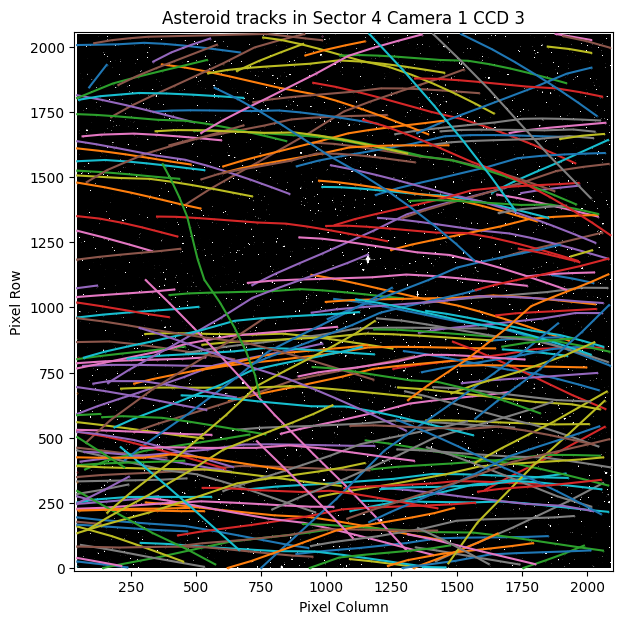

In [208]:
plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
# plt.scatter(col_2d, row_2d, s=1, c=f2d, vmin=500, vmax=5000)
plt.pcolormesh(col_2d, row_2d, f2d, vmin=400, vmax=2000, cmap="Greys_r")
# plt.scatter(fficut_aster.column, fficut_aster.row, s=1, label="TESScut", c="k")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    val = val.query(f"camera == {camera} and ccd == {ccd}")
    plt.plot(val.column[::100], val.row[::100], ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

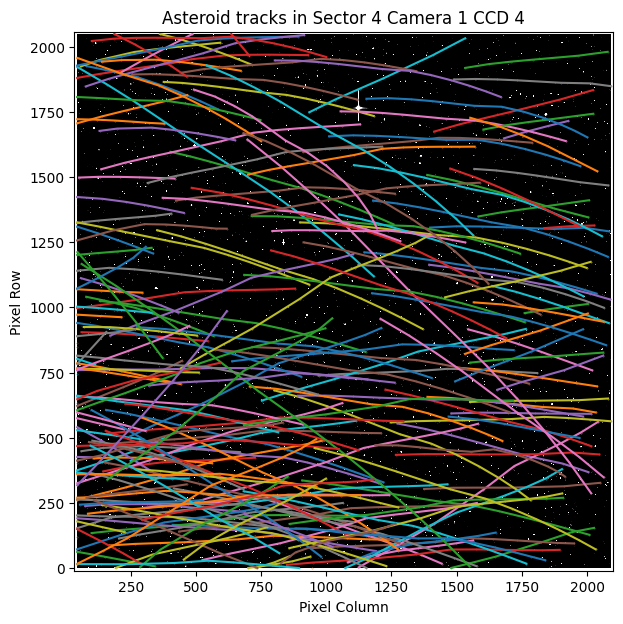

In [218]:
plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
# plt.scatter(col_2d, row_2d, s=1, c=f2d, vmin=500, vmax=5000)
plt.pcolormesh(col_2d, row_2d, f2d, vmin=400, vmax=2000, cmap="Greys_r")
# plt.scatter(fficut_aster.column, fficut_aster.row, s=1, label="TESScut", c="k")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    val = val.query(f"camera == {camera} and ccd == {ccd}")
    plt.plot(val.column[::100], val.row[::100], ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [219]:
def get_cutout_centers(
    ncol: int = 2048,
    nrow: int = 2048,
    sampling: str = "tiled",
    overlap: int = 0,
    size: int = 50,
    ncuts: int = 20,
):
    """
    Get the i,j of the centers for a sample of cutouts given a cutout size and a
    sampling strategy.
    """
    if sampling == "tiled":
        dx = 2
        xcen = np.arange(dx, ncol - dx, size - overlap)
        ycen = np.arange(dx, nrow - dx, size - overlap)
    elif sampling == "random":
        xcen, ycen = np.random.randint(0 + dx, ncol - dx, (2, ncuts))
    else:
        raise NotImplementedError
    xcen, ycen = np.meshgrid(xcen, ycen)
    return xcen, ycen

In [220]:
get_cutout_centers(sampling="tiled", overlap=5, size=50)

(array([[   2,   47,   92, ..., 1937, 1982, 2027],
        [   2,   47,   92, ..., 1937, 1982, 2027],
        [   2,   47,   92, ..., 1937, 1982, 2027],
        ...,
        [   2,   47,   92, ..., 1937, 1982, 2027],
        [   2,   47,   92, ..., 1937, 1982, 2027],
        [   2,   47,   92, ..., 1937, 1982, 2027]]),
 array([[   2,    2,    2, ...,    2,    2,    2],
        [  47,   47,   47, ...,   47,   47,   47],
        [  92,   92,   92, ...,   92,   92,   92],
        ...,
        [1937, 1937, 1937, ..., 1937, 1937, 1937],
        [1982, 1982, 1982, ..., 1982, 1982, 1982],
        [2027, 2027, 2027, ..., 2027, 2027, 2027]]))